# Decision Trees for Classification

In [1]:
# %cd "C:\\Users\\yasin.unlu\\Documents\\Original Docs\\Documents1\\Docs\\Teaching\\PythonForDataScienceSummer2020\\Week-8"
import pandas as pd
df = pd.read_csv('data\\play.csv')


df.drop(axis=1, columns='Day', inplace=True)

#Encoding categorical data values
from sklearn.preprocessing import LabelEncoder
df_clean = df.copy() 
labelencoder = LabelEncoder()
df_clean['Weather'] = labelencoder.fit_transform(df['Weather'])
df_clean['Temperature'] = labelencoder.fit_transform(df['Temperature'])
df_clean['Play'] = labelencoder.fit_transform(df['Play'])

#Feature Scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 2)) #set max range to 2 because weather can go upto 2.
# df_clean['Humidity'] = scaler.fit_transform(df[['Humidity']])
# df_clean['Wind'] = scaler.fit_transform(df[['Wind']])

features = df_clean.loc[:,'Weather':'Wind']
response = df_clean[['Play']]

from sklearn.model_selection import train_test_split
my_result_list = train_test_split(features, response, test_size=0.30, random_state=0)
features_train, features_test, response_train, response_test = my_result_list

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(features_train, response_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [2]:
features

,Weather,Temperature,Humidity,Wind
0,2,1,90,10
1,0,1,95,5
2,2,2,70,30
3,0,2,89,25
4,1,2,85,25
5,1,0,60,30
6,1,2,92,20
7,2,1,95,20
8,0,1,65,12
9,1,2,100,25


[Text(111.60000000000001, 190.26, 'Weather <= 0.5\ngini = 0.49\nsamples = 7\nvalue = [4, 3]'),
 Text(55.800000000000004, 135.9, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 135.9, 'Temperature <= 1.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(223.20000000000002, 81.53999999999999, 'Humidity <= 96.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(279.0, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

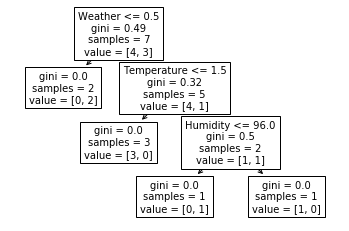

In [3]:
from sklearn.tree import plot_tree
plot_tree(classifier, feature_names = features.columns.tolist())

A **node** in the tree represents a feature. The tree starts splitting with the node that has the highest gini impurity index value. Another metric is so-called **entropy**.

**Gini** (gini impurity index) quantifies how quality the split is. In other words, it measures how heterogeneous or mixed some value is over a set.

Decision tree algorithm in scikit learn package creates its own partititions for each node. Total number of partitions are called **samples** in each nodel. 

**Value** is the split of the samples at each node. For example, at the root node (the top node), 7 samples are divided into two child nodes of 4 and 3 samples each.

Final nodes in the tree are called **leaf** (terminal) nodes. They lead to classification or decision.

### Report Feature Importance

In [4]:
importance = classifier.feature_importances_
feature_names = features.columns.to_list()

# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

Weather: 0.53333
Temperature: 0.17500
Humidity: 0.29167
Wind: 0.00000


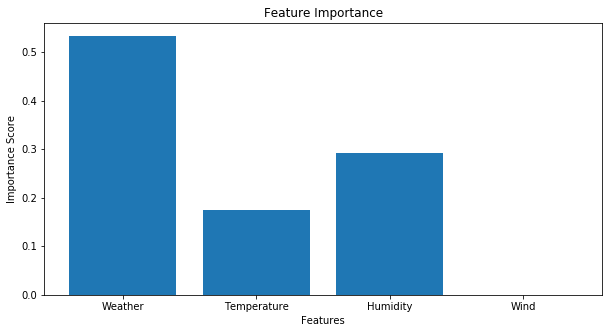

In [5]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))
# plot feature importance
pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()

## Parameter Tuning with Grid Search

We trained the decision tree model with the default parameters. 

**Default Parameters**
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

We can create a small set of experiments to search for best parameters, which is called "Parameter Tuning". scikit learn package provides a grid search function. This creates a set of candicate parameters and the corresponding experiment is conducted by trying every candidate parameter. The grid search function returns the best candidate parameters. Experimental environment is created by using **k-fold cross validation**.<br/>

**Cross-validation:**Think of estimating the performance of a model for a given combination of parameters. We want to estimate the performance in a rigorous way. 

We create k folds from the data. In each fold, we fit the model and evaluate the performance over the test data within that fold. Test and train data sets are chosen in each fold according the method depicted in the image below. The value of k shouldn’t be too small or too high, ideally we choose 5 to 10 depending on the data size.


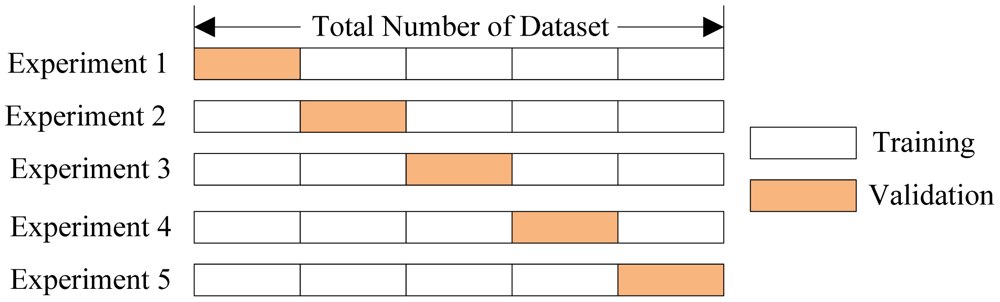

Let's write a small function that performs grid search.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

def grid_search(X, y, kfolds):
    
    #create a dictionary of all values we want to test
    param_grid = {'criterion':['gini','entropy'], 'max_depth': np.arange(3, 15)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=kfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [7]:
grid_search(X = features_train, y = response_train, kfolds = 3)

{'criterion': 'gini', 'max_depth': 3}

Let's re-train our model with the tuned parameters and produce predictions over the test horizon.

In [8]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 0)
classifier.fit(features_train, response_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [9]:
response_pred = classifier.predict(features_test)
print('Predictions ',response_pred)
print('Actuals ',list(response_test['Play']))

Predictions  [1 1 1]
Actuals  [1, 1, 0]


## Example: Iris Data

In [10]:
import pandas as pd
df = pd.read_csv('https://sites.google.com/site/yasinunlu/home/research/new1/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [11]:
df.species.drop_duplicates() #there are 3 flower species.

0          setosa
50     versicolor
100     virginica
Name: species, dtype: object

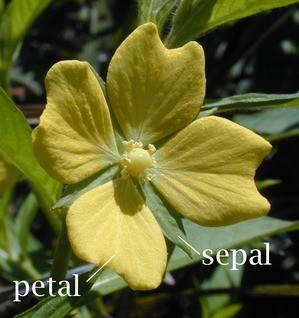

Let's create the input data.

In [12]:
# features = df_clean.loc[:,'Weather':'Wind']
response = df[['species']]
features = df.loc[:,'sepal_length':'petal_width']

from sklearn.model_selection import train_test_split
my_result_list = train_test_split(features, response, test_size=0.30, random_state=0)
features_train, features_test, response_train, response_test = my_result_list

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
classifier.fit(features_train, response_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [34]:
a.shape

(45, 2)

In [35]:
df.shape

(506, 14)

In [14]:
import numpy as np
response_pred = classifier.predict(features_test)
# print('Predictions ',response_pred)
# print('Actuals ',list(response_test['species']))

a = np.array([response_pred, list(response_test['species'])])
a = a.transpose()
df_preds = pd.DataFrame(a, columns=['Predictions', 'Actuals'])
df_preds.head()

,Predictions,Actuals
0,virginica,virginica
1,versicolor,versicolor
2,setosa,setosa
3,virginica,virginica
4,setosa,setosa


In [15]:
from sklearn.metrics import accuracy_score
print('Accuracy Score on test data: ', accuracy_score(y_true=response_test, y_pred=response_pred))

Accuracy Score on test data:  0.9777777777777777


In [16]:
importance = classifier.feature_importances_
feature_names = features.columns.to_list()

# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

sepal_length: 0.00000
sepal_width: 0.02150
petal_length: 0.39767
petal_width: 0.58083


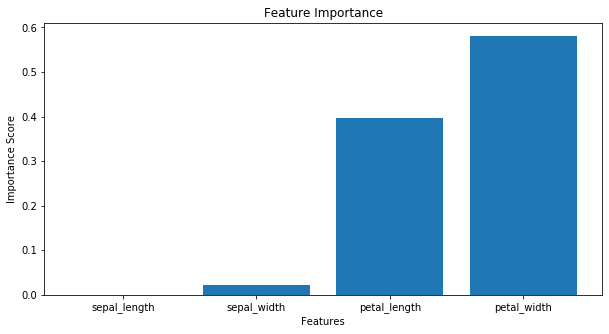

In [17]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))
# plot feature importance
pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()

# Decision Trees for Regression
Decision trees can also be used for regression. We can predict a continuous value of a response variable by applying the same tree building steps. The predictions are the average values of observations in leaf nodes. 

#### Example: Boston House Prices

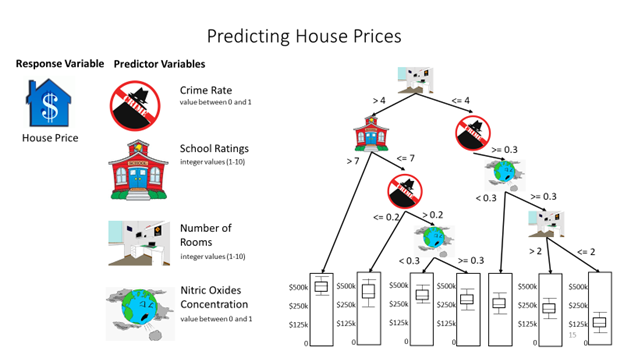

## Step-1: Create a Dataframe 

In [18]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()
df  = pd.DataFrame(boston.data, columns = boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Step-2: Identify Features and Response Variable

In [19]:
from sklearn.model_selection import train_test_split
features = df.iloc[:,0:13] #First 13 columns in dataframe accounts for features
features.head() #this is a dataframe

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [20]:
response = df[['MEDV']] #create a dataframe for response variable
response.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


## Step-3: Prepare Test and Train Data

In [21]:
my_result_list = train_test_split(features, response, test_size=0.2, random_state=0)

features_train = my_result_list[0]
features_test = my_result_list[1]
response_train = my_result_list[2]
response_test = my_result_list[3]

## Step-4: Fit Model to Train Data

We will use `DecisionTreeRegressor` function from scikit learn package.

In [22]:
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor (random_state = 0)
regressor.fit(features_train, response_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

## Step-5: Test and Evaluate the Model
Let's first generate the predictions.

In [23]:
response_pred = regressor.predict(features_test)

Now let's evaluate the performance of the model.

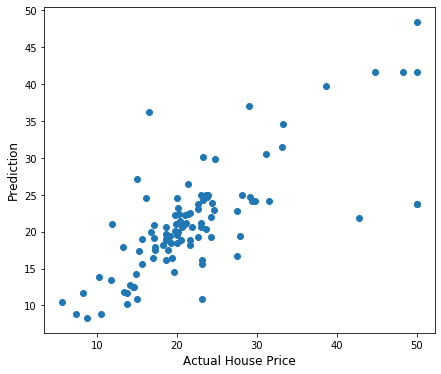

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.scatter(response_test, response_pred)
plt.ylabel('Prediction', size = 12)
plt.xlabel('Actual House Price', size = 12)
plt.show()

In [25]:
import numpy as np
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(response_test, response_pred))
print('Mean Squared Error:', metrics.mean_squared_error(response_test, response_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(response_test, response_pred)))

Mean Absolute Error: 3.715686274509804
Mean Squared Error: 36.93627450980392
Root Mean Squared Error: 6.077522069873866


## Step-6: Improve Results with Parameter Tuning

We trained the decision tree model with the default parameters. 

**Default Parameters**
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [41]:
help(DecisionTreeRegressor)

Help on class DecisionTreeRegressor in module sklearn.tree._classes:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"mse", "friedman_mse", "mae"}, default="mse"
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion and minimizes the L2 loss
 |      using the mean of each terminal node, "friedman_mse", which uses mean
 |      squared error with Friedman's improvement score for potential spli

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def grid_search(X, y, kfolds):
    
    #create a dictionary of all values we want to test
    param_grid = {'criterion':["mse", "friedman_mse", "mae"], 
                  'max_depth': np.arange(3, 15),
                  'splitter': ["best", "random"] }
    # decision tree model
    dtree_model=DecisionTreeRegressor()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=kfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [27]:
grid_search(X = features_train, y = response_train, kfolds = 5)

{'criterion': 'friedman_mse', 'max_depth': 8, 'splitter': 'random'}

In [28]:
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor (random_state = 0, criterion= 'friedman_mse', max_depth= 8, splitter= 'best')
regressor.fit(features_train, response_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [29]:
response_pred = regressor.predict(features_test)

In [30]:
import numpy as np
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(response_test, response_pred))
print('Mean Squared Error:', metrics.mean_squared_error(response_test, response_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(response_test, response_pred)))

Mean Absolute Error: 3.4680514783672223
Mean Squared Error: 33.44442843975845
Root Mean Squared Error: 5.783115807223512


####  Q: Does this beat multiple regression?

### Report Feature Importance

In [31]:
importance = regressor.feature_importances_
feature_names = features.columns.to_list()

# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

CRIM: 0.02807
ZN: 0.00000
INDUS: 0.00597
CHAS: 0.00000
NOX: 0.01357
RM: 0.23684
AGE: 0.00676
DIS: 0.04721
RAD: 0.00524
TAX: 0.01150
PTRATIO: 0.03512
B: 0.00950
LSTAT: 0.60021


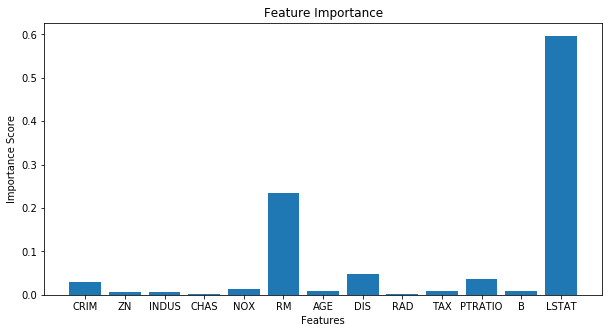

In [50]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))
# plot feature importance
pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()